In [6]:
import umap
import sklearn.datasets
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

###   t-SNE, UMAP and LargeVis

In this and the next notebook we will use manifold learning for data visualization of large data sets (with high dimensionality). In addition to t-SNE, two relatively new methods will be used that are more efficient on large data sets.


- UMAP (Uniform Manifold Approximation and Projection) - Install this Python package: https://umap-learn.readthedocs.io/en/latest/index.html. UMAP package is compatible with scikit-learn, making use of the same API and able to be added to sklearn pipelines. UMAP can work as a drop in replacement for t-SNE and other dimension reduction classes from scikit-learn


- LargeVis (Visualizing Large-scale and High-dimensional Data) - Many techniques (like t-SNE, UMAP and LargeVis) first compute a similarity structure of the data points and then project them into a low-dimensional space with the structure preserved. These two steps suffer from considerable computational costs Comparing to tSNE, LargeVis significantly reduces the computational cost of the graph construction step and employs a principled probabilistic model for the visualization step, the objective of which can be effectively optimized through asynchronous stochastic gradient descent with a linear time complexity. Download this algorithm repository and follow the installation instructions. https://github.com/lferry007/LargeVis


In [7]:
from sklearn.manifold import TSNE
import umap

To get data we use the sklearn.datasets.fetch_openml method, which as the name requires, Fetch dataset from openml by name or dataset id. We will use MNIST and Fashion-MNIST(Zalando's article images). Fashion-MNIST is intended to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. Instead of numbers it contains thumbnails of clothes images.

In [8]:
mnist_full = sklearn.datasets.fetch_openml('mnist_784')
fmnist_full = sklearn.datasets.fetch_openml('Fashion-MNIST')

In [9]:
# mnist.data.shape
import types

LIMIT = mnist_full.data.shape[0]

mnist_limited = types.SimpleNamespace()
mnist_limited.data = mnist_full.data[:LIMIT]
mnist_limited.target = mnist_full.target[:LIMIT]

fmnist_limited = types.SimpleNamespace()
fmnist_limited.data = fmnist_full.data[:LIMIT]
fmnist_limited.target = fmnist_full.target[:LIMIT]

In [10]:
mnist = mnist_limited
fmnist = fmnist_limited

Below are drawings of some samples from mnist and fmnist data sets

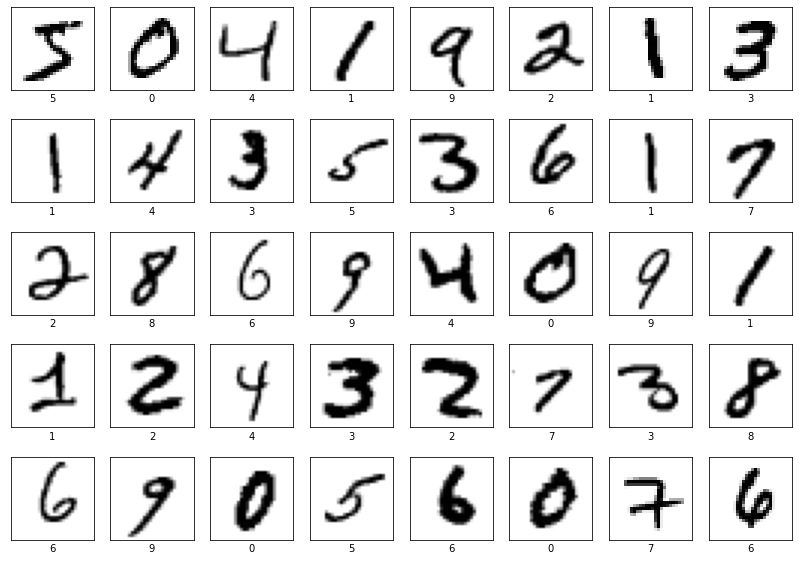

In [11]:
mnist_names = [i for i in range(10)]

plt.figure(figsize=(14,10))
for i in range(40):
    plt.subplot(5, 8, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(mnist.data.iloc[i].to_numpy().reshape((28, 28)), cmap=plt.cm.binary)
    plt.xlabel(mnist_names[int(mnist.target[i])])
plt.show()

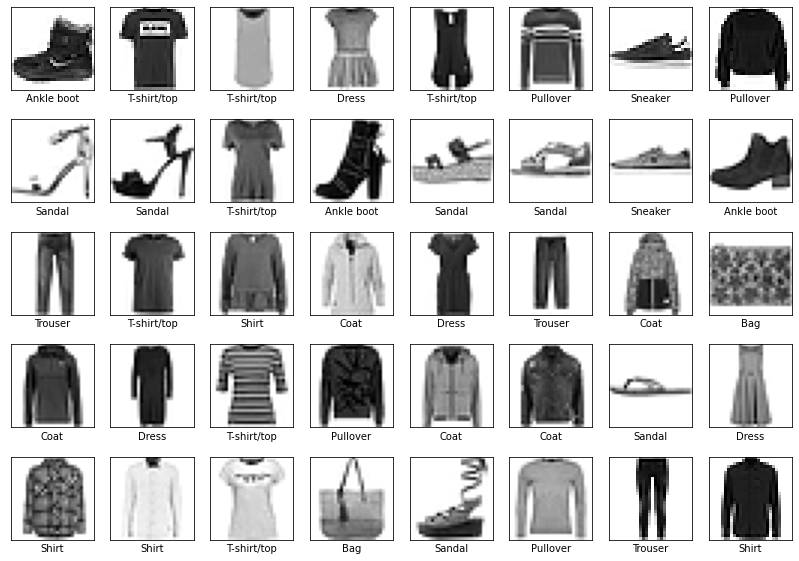

In [12]:
fmnist_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
 
plt.figure(figsize=(14,10))
for i in range(40):
    plt.subplot(5, 8, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(fmnist.data.iloc[i].to_numpy().reshape((28, 28)), cmap=plt.cm.binary)
    plt.xlabel(fmnist_names[int(fmnist.target[i])])
plt.show()

#### Use t-SNE, UMAP and LargeVis to project mnist and fmnist data sets into a 2-dimensional space. For LargeVis, you need to create a function that saves the data to the required by LargeVis txt file format, and a function that loads the resulting file. Draw charts for all visualizations.

In [93]:
from sklearn.manifold import TSNE

def run_tsne(points):
    points_transformed = TSNE(n_components=2,
                              metric='euclidean',
                              perplexity=40.,
                              n_iter=1000,
                              # init='pca',
                              learning_rate='auto').fit_transform(points)
    return points_transformed

In [86]:
plt.rcParams["figure.figsize"] = [16, 12]
plt.rcParams["font.size"] = 20

def visualize_points(points, target, title):
    fig, ax = plt.subplots()

    target_labels = target.to_numpy().astype(np.int8)
    for group in np.unique(target_labels):
        idx = np.where(target_labels == group)[0]
        im = ax.scatter(points[idx][:, 0], points[idx][:, 1], cmap=plt.cm.coolwarm, label=group, s=1)

    ax.set_title(title)
    ax.set_xlabel('X Component')
    ax.set_ylabel('Y Component')
    ax.legend(fontsize=10, markerscale=10.0)

## TSNE

We can see that tsne successfully separated classes but mostly in a 'local' sense.
Local meaning instances of the same class are close together, whereas 'global' would mean
that instances of different but similar classes are also close together
(ideally not as close as instances of the same classes) but closer than others.

We can also note that for fmnist we didn't even get that clear separation as we did for mnist.

We could achieve better local separation with tsne by tweaking tsne params, but it would be hard to achieve better 'global' separation,
since tsne focuses on 'local' separation.

In [94]:
mnist_tsne_X = run_tsne(mnist.data)

/Users/pwojtyczek/.conda/envs/visualizing-big-datasets/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


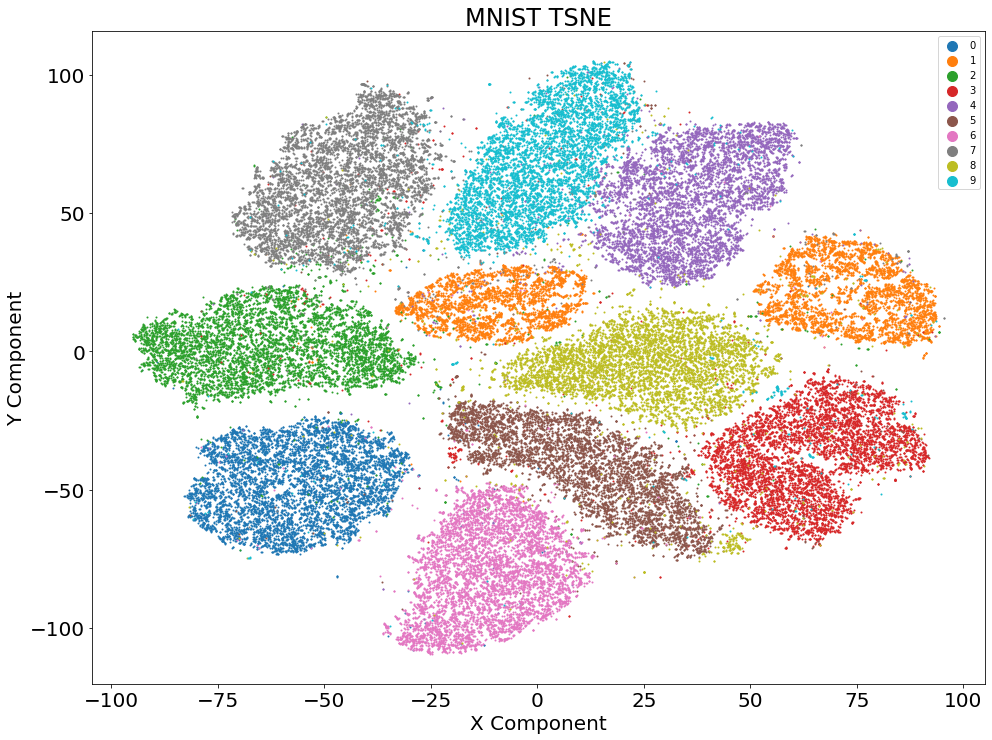

In [98]:
visualize_points(mnist_tsne_X, mnist.target, title="MNIST TSNE")

In [96]:
fmnist_tsne_X = run_tsne(fmnist.data)

/Users/pwojtyczek/.conda/envs/visualizing-big-datasets/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


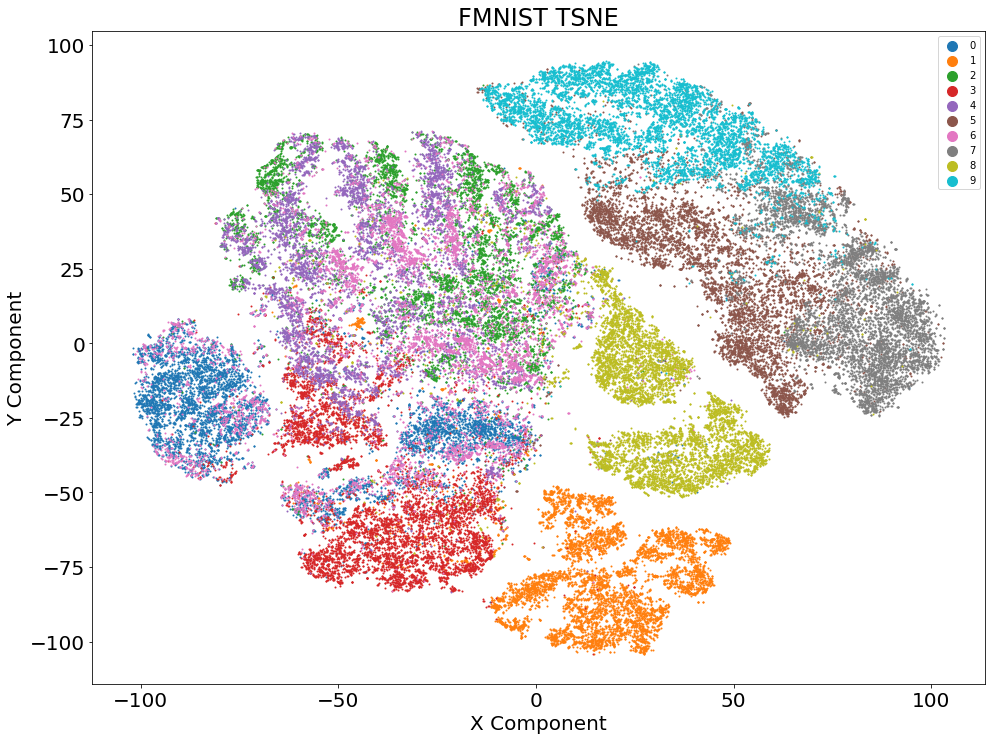

In [97]:
visualize_points(fmnist_tsne_X, fmnist.target, title='FMNIST TSNE')

## UMAP

We can see that umap does a better job at preserving global data structure.
For example classes like '3' - red, '8' - yellow, '5' - 'brown' constitute a local cluster, which makes
sense as 3 looks somewhat like 8.


Similarly, for FMNIST, classes 9, 7 and 5 which are 'Ankle boot', 'Sneaker' and 'Sandal' also constitute a local cluster
which once again makes sense as that's a cluster with all kinds of footwear.

We can also see that it failed to separate 'Coat' - 6 from other classes (bottom right), but overall it did a better job at
visualizing both datasets as it preserved more of a global structure of the underling datasets.


In [17]:
umap_mapper_mnist = umap.UMAP().fit(mnist.data)
mnist_umap_X = umap_mapper_mnist.embedding_

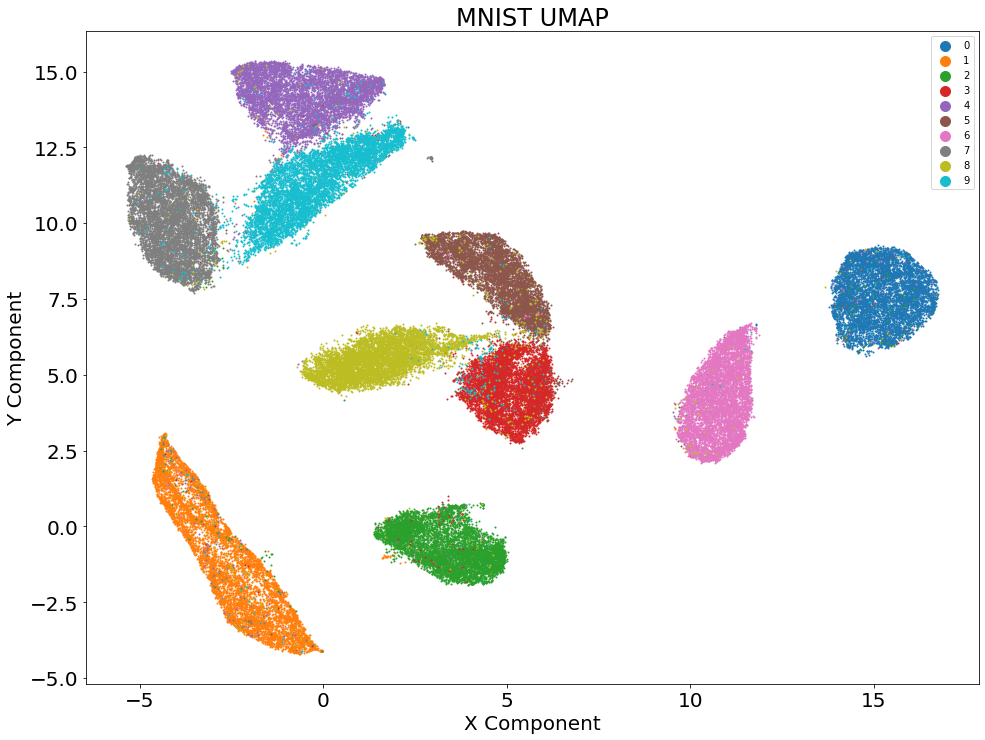

In [89]:
visualize_points(mnist_umap_X, mnist.target, title='MNIST UMAP')

In [19]:
# import umap.plot
# umap.plot.points(umap_mapper_mnist, labels=fmnist.target)

In [20]:
umap_mapper_fmnist = umap.UMAP().fit(fmnist.data)
fmnist_umap_X = umap_mapper_fmnist.embedding_

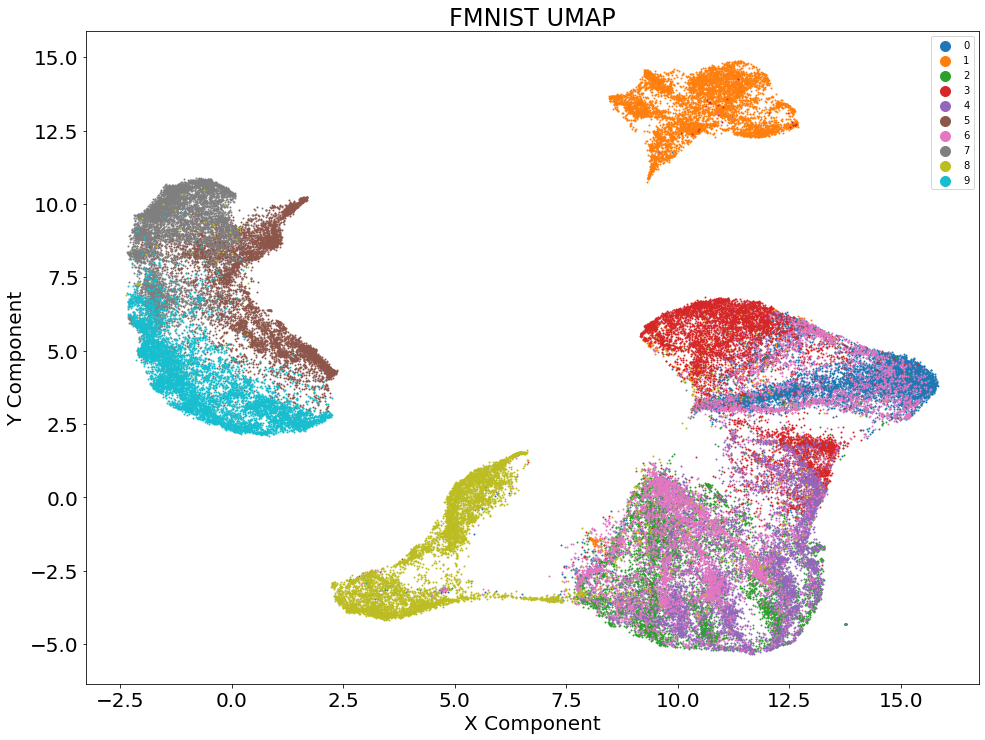

In [90]:
visualize_points(fmnist_umap_X, fmnist.target, title='FMNIST UMAP')

In [22]:
def save_largevis_input_data(data, filename):
    with open(filename, 'w') as f:
        shape = data.shape
        f.write(f'{shape[0]} {shape[1]}\n')
        for i in range(shape[0]):
            row = data.iloc[i].to_numpy()
            vals = []
            for v in row:
                vals.append(f'{v} ')
            f.write(''.join(vals) + '\n')

In [23]:
save_largevis_input_data(mnist.data, 'mnist_data.txt')
save_largevis_input_data(fmnist.data, 'fmnist_data.txt')

# At this point you should run largevis.
#! ./LargeVis/Linux/LargeVis -input ./lab3/fmnist_data.txt  -output ./lab3/fmnist_output.txt

In [24]:
def load_largevis_embedding(input_filename, limit=None):
    N = None
    with open(input_filename) as f:
        line = f.readline()
        vec = line.strip().split(' ')
        N = vec[0]

    embedding = []
    file_iterator = enumerate(open(input_filename))
    next(file_iterator)
    for i, line in file_iterator:
        vec = line.strip().split(' ')
        embedding.append(np.array([float(vec[0]), float(vec[1])]))
        if i == limit:
            break

    return np.array(embedding)

In [25]:
# largevis_mnist_data, largevis_mnist_label = load_data('./mnist_output.txt', mnist.target, LIMIT)
mnist_largevis_X = load_largevis_embedding('./mnist_output.txt', LIMIT)

## LARGEVIS

LargeVis is similar to umap as it also tries to preserve global data structure.
We can even see that the same clusters have formed - ('3', '5' and '8') constitute a cluster in largevis and it also did
in umap minst.

Similarly, for FMNIST, classes 9, 7 and 5 which are 'Ankle boot', 'Sneaker' and 'Sandal' also formed a cluster.
'Trouser' class which is a unique class, forms a separate cluster.


It seems as if largevis was even more focused on extracting the global structure as it creates even more clusters, but
local separation in fmnist wasn't as good as it was in umap.


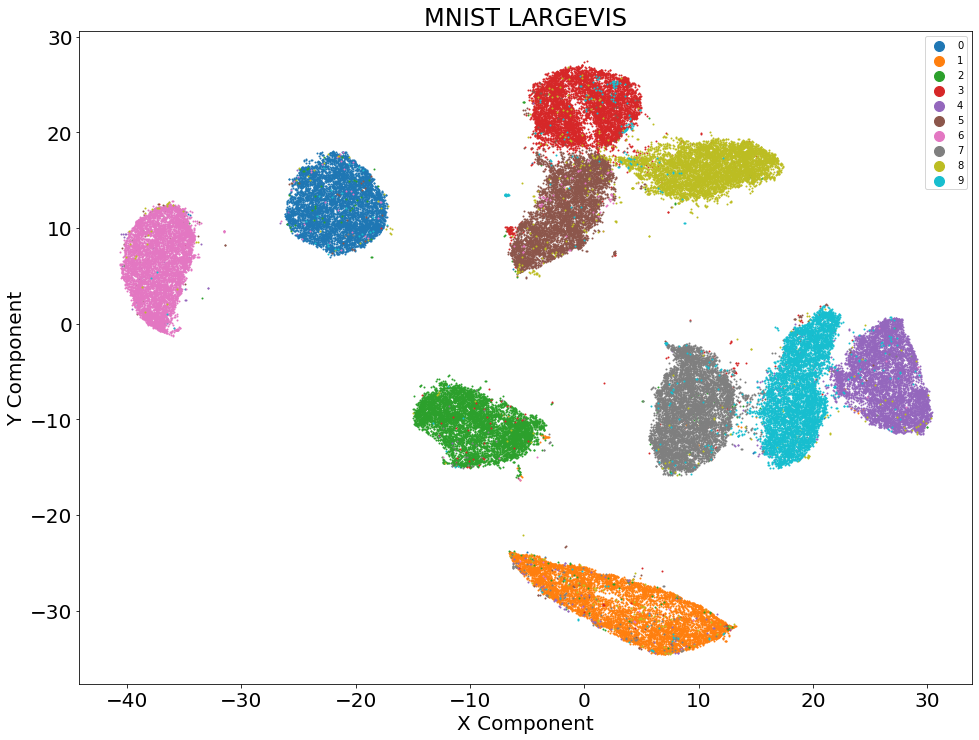

In [91]:
# show_largevis(largevis_mnist_data)
visualize_points(mnist_largevis_X, mnist.target, 'MNIST LARGEVIS')

In [27]:
fmnist_largevis_X = load_largevis_embedding('./fmnist_output.txt', LIMIT)

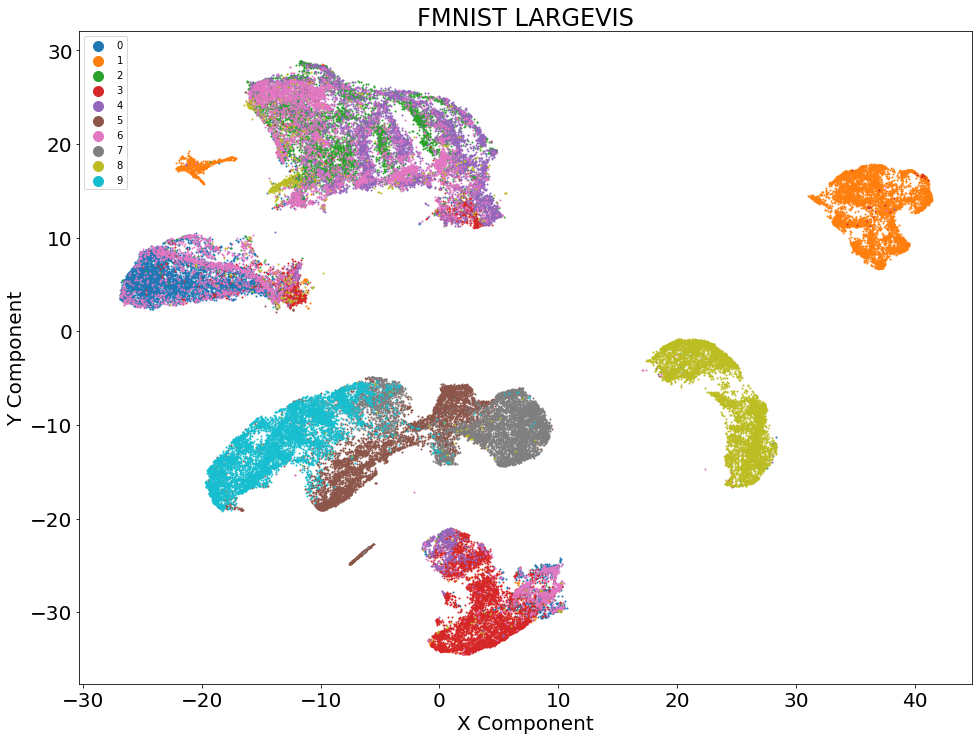

In [92]:
visualize_points(fmnist_largevis_X, fmnist.target, 'FMNIST LARGEVIS')


#### In order to compare the results of these three methods, calculate for each case the average distance between two points belonging to the same class divided by the average distance between points belonging to 2 different classes

In [42]:
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans

def compute_inter_class_avg_dist(embedded_X, target):
    target_labels = target.to_numpy().astype(np.int8)
    centers = KMeans(n_clusters=np.unique(target_labels).shape[0]).fit(embedded_X).cluster_centers_
    n = centers.shape[0]

    n_distances = (((n * n) / 2) - n)
    return np.sum(cdist(centers, centers) / 2) / n_distances

In [43]:
def simple_avg_metric(embedded_X, target, method='group', group_size=500):
    target_labels = target.to_numpy().astype(np.int8)
    result_per_label = {}

    cross_class_dist = 0.0
    cross_class_count = 0
    for label in np.unique(target_labels):
        class_idx = np.where(target_labels == label)[:group_size]
        non_class_idx = np.where(target_labels != label)[:group_size]

        class_points = embedded_X[class_idx]

        n = class_points.shape[0]
        within_class_distances = np.sum(cdist(class_points, class_points)) / 2
        result_per_label[label] = within_class_distances / (((n * n) / 2) - n)

        if method == 'group':
            non_class_points = embedded_X[non_class_idx]
            cross_class_dist += np.sum(cdist(class_points, non_class_points))
            cross_class_count += class_points.shape[0] * non_class_points.shape[0]

    avg_cross_class_dist = 0.
    if method == 'knn':
        avg_cross_class_dist = compute_inter_class_avg_dist(embedded_X, target)
    elif method == 'group':
        avg_cross_class_dist = cross_class_dist / cross_class_count

    acc = 0.
    for k, v in result_per_label.items():
        result_per_label[k] = v / avg_cross_class_dist
        acc += result_per_label[k]

    result_per_label['sum'] = acc

    return result_per_label

def simple_metrics(data, method='group'):
    mnist_simple_metrics = list(map(lambda e:
                                    pd.DataFrame.from_dict(e[0], orient='index', columns=[e[1]]),
                                    map(lambda e: (simple_avg_metric(e[0], e[1], method=method), e[2]), data)))
    return pd.concat(mnist_simple_metrics, axis=1)

## Simple Metrics

To compute average distance between points in different classes I've used two methods:
- knn - a cluster center is used to approximate all points within a class and is used to calculate distances between different classes
- group - instead of calculating distances between ALL points (which is a lot - 70k x 70k) I pick 500 points from each class to estimate avg distance between different classes.

Each class has its own metric, so to create a summary for a method I've summed metrics from all classes.
Both methods return similar results, so I won't be discussing them separately.
Also, this metric doesn't really tell us anything about global data structure preservation, but it's a reasonable metric for local separation.


For MNIST largevis seem to have the best performance with umap close behind it.
For FMNIST we can see that umap is the best performing method - whereas both largevis and tsne achieve similar results.
This shows that this metric fails to capture the difference between global/local separation as tsne doesn't achieve global separation yet
it has the same score as largevis.

In [105]:
simple_metrics([
    (mnist_tsne_X, mnist.target, 'MNIST TSNE'),
    (mnist_umap_X, mnist.target, 'MNIST UMAP'),
    (mnist_largevis_X, mnist.target, 'MNIST LARGEVIS'),
    (fmnist_tsne_X, fmnist.target, 'FMNIST TSNE'),
    (fmnist_umap_X, fmnist.target, 'FMNIST UMAP'),
    (fmnist_largevis_X, fmnist.target, 'FMNIST LARGEVIS')
])

,MNIST TSNE,MNIST UMAP,MNIST LARGEVIS,FMNIST TSNE,FMNIST UMAP,FMNIST LARGEVIS
0,0.254945,0.151297,0.140027,0.506762,0.268511,0.528127
1,0.554637,0.279832,0.225787,0.340270,0.255770,0.585950
2,0.303854,0.200734,0.183530,0.464675,0.276754,0.284033
3,0.318493,0.154449,0.184546,0.397532,0.295022,0.527584
4,0.288436,0.187913,0.193804,0.471310,0.290360,0.464458
5,0.315619,0.181125,0.188324,0.396459,0.265947,0.280203
6,0.265950,0.164891,0.171271,0.568938,0.429000,0.629283
7,0.302361,0.190004,0.172788,0.363617,0.197970,0.231694
8,0.309053,0.196222,0.220245,0.349520,0.291456,0.416268
9,0.337723,0.220960,0.229936,0.333670,0.201532,0.194817


In [100]:
simple_metrics([
    (mnist_tsne_X, mnist.target, 'MNIST TSNE'),
    (mnist_umap_X, mnist.target, 'MNIST UMAP'),
    (mnist_largevis_X, mnist.target, 'MNIST LARGEVIS'),
    (fmnist_tsne_X, fmnist.target, 'FMNIST TSNE'),
    (fmnist_umap_X, fmnist.target, 'FMNIST UMAP'),
    (fmnist_largevis_X, fmnist.target, 'FMNIST LARGEVIS')
], method='knn')

,MNIST TSNE,MNIST UMAP,MNIST LARGEVIS,FMNIST TSNE,FMNIST UMAP,FMNIST LARGEVIS
0,0.228380,0.135012,0.122505,0.452592,0.249314,0.458228
1,0.496843,0.249711,0.197534,0.303897,0.237484,0.508398
2,0.272192,0.179128,0.160565,0.415003,0.256968,0.246440
3,0.285306,0.137825,0.161454,0.355038,0.273929,0.457757
4,0.258381,0.167687,0.169553,0.420929,0.269600,0.402986
5,0.282731,0.161629,0.164759,0.354079,0.246933,0.243117
6,0.238237,0.147143,0.149840,0.508121,0.398329,0.545995
7,0.270855,0.169553,0.151167,0.324748,0.183816,0.201029
8,0.276850,0.175101,0.192686,0.312158,0.270618,0.361174
9,0.302532,0.197176,0.201164,0.298003,0.187124,0.169032


In [33]:
%load_ext autoreload
%autoreload
from local_score import *

In [101]:
X = mnist.data
labels = mnist.target

mnist_local_metrics = LocalMetric()
mnist_local_metrics.calculate_knn_gain_and_dr_quality(
    X_lds=mnist_tsne_X,
    X_hds=X.values,
    labels=labels.values.to_numpy(dtype=np.int8),
    method_name="{} {}".format("mnist", "tsne"),
)

mnist_local_metrics.calculate_knn_gain_and_dr_quality(
    X_lds=mnist_umap_X,
    X_hds=X.values,
    labels=labels.values.to_numpy(dtype=np.int8),
    method_name="{} {}".format("mnist", "umap"),
)

mnist_local_metrics.calculate_knn_gain_and_dr_quality(
    X_lds=mnist_largevis_X,
    X_hds=X.values,
    labels=labels.values.to_numpy(dtype=np.int8),
    method_name="{} {}".format("mnist", "largevis"),
)

Calculating d_hd
mnist tsne
Calculating d_hd
mnist umap
Calculating d_hd
mnist largevis


### Local Score metrics

Metrics from provided script.
- DR quality (dimensionality reduction quality(
- Knn gain.
Essentially they compare neighbourhoods of original dataset and embedded dataset and see how alike they're.

Ideally those metrics would reach maximum around neighbourhood size ~ number of instances per class.
As we have ten classes and we use 0.15 test instances that would be:
0.1 * 0.15 * 70000 ~ 10^3.

We can see that it's indeed the case as max is around 10^3.

Umap and largevis look very similar on these plots, except for tsne.
Looking at DR quality, we can see that tsne has high score even for small neighbourhoods in contrast to umap and largevis which "catch up"
as we start to consider larger and larger neighbourhoods. This is mostly due to the fact that tsne focuses on "local structure".

Sadly these metrics also don't tell us much about global structure.

Finished.


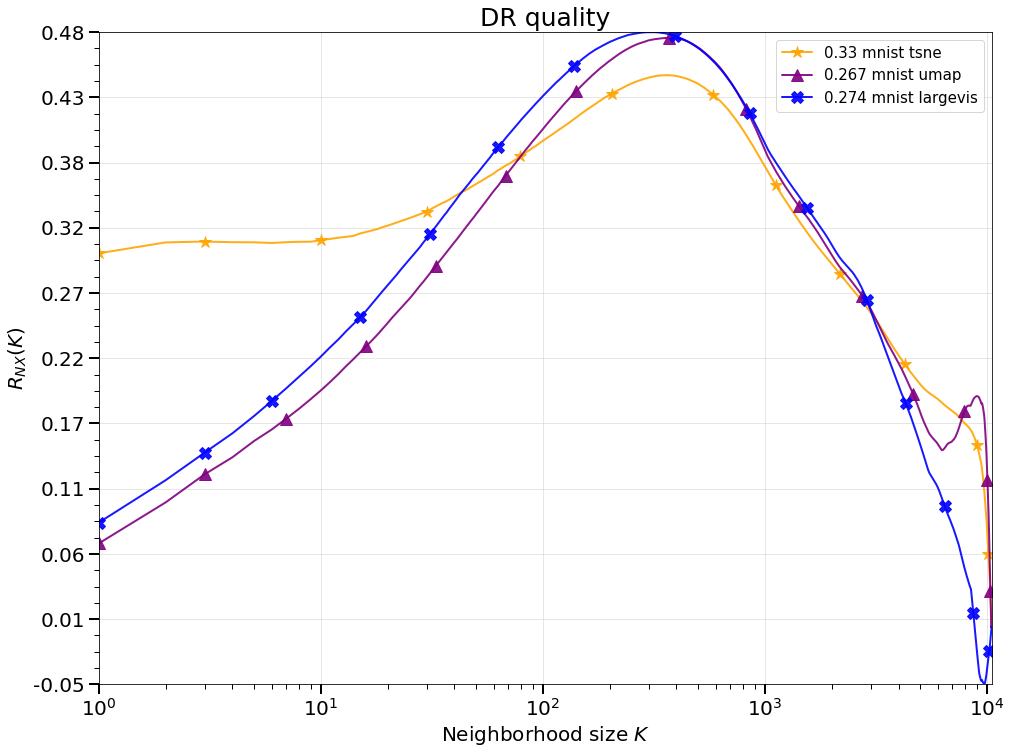

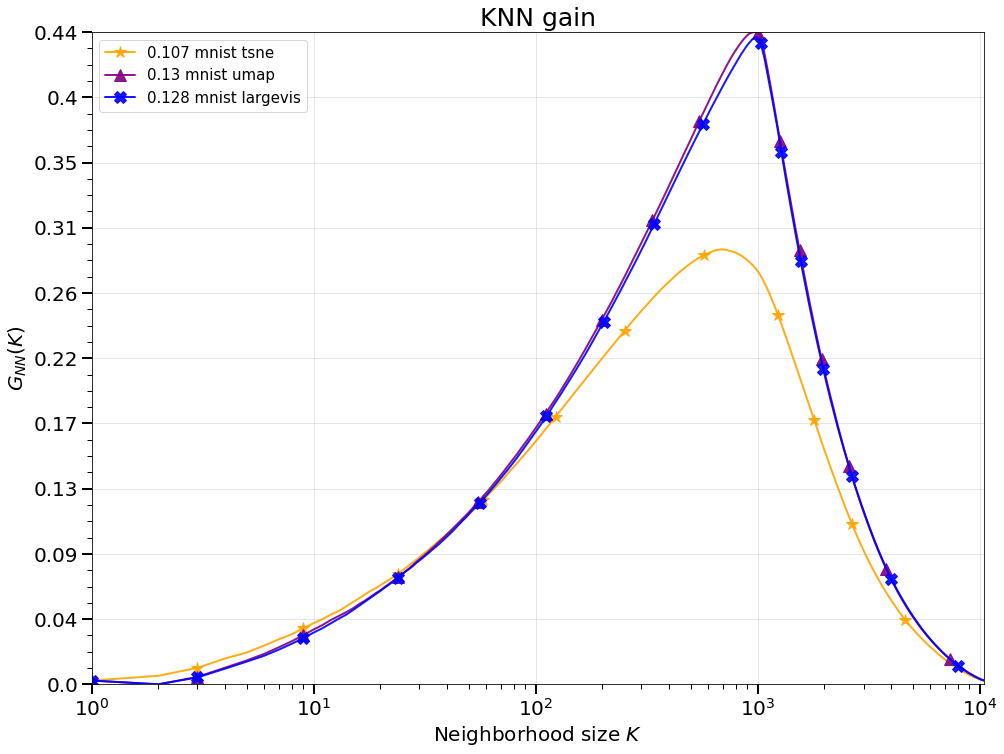

In [102]:
mnist_local_metrics.visualize()
# there's also a second metric which wasn't calculated, refresh this module.

In [103]:
X = fmnist.data
labels = fmnist.target

fmnist_local_metrics = LocalMetric()
fmnist_local_metrics.calculate_knn_gain_and_dr_quality(
    X_lds=fmnist_tsne_X,
    X_hds=X.values,
    labels=labels.values.to_numpy(dtype=np.int8),
    method_name="{} {}".format("fmnist", "tsne"),
)

fmnist_local_metrics.calculate_knn_gain_and_dr_quality(
    X_lds=fmnist_umap_X,
    X_hds=X.values,
    labels=labels.values.to_numpy(dtype=np.int8),
    method_name="{} {}".format("fmnist", "umap"),
)

fmnist_local_metrics.calculate_knn_gain_and_dr_quality(
    X_lds=fmnist_largevis_X,
    X_hds=X.values,
    labels=labels.values.to_numpy(dtype=np.int8),
    method_name="{} {}".format("fmnist", "largevis"),
)

Calculating d_hd
fmnist tsne
Calculating d_hd
fmnist umap
Calculating d_hd
fmnist largevis


Finished.


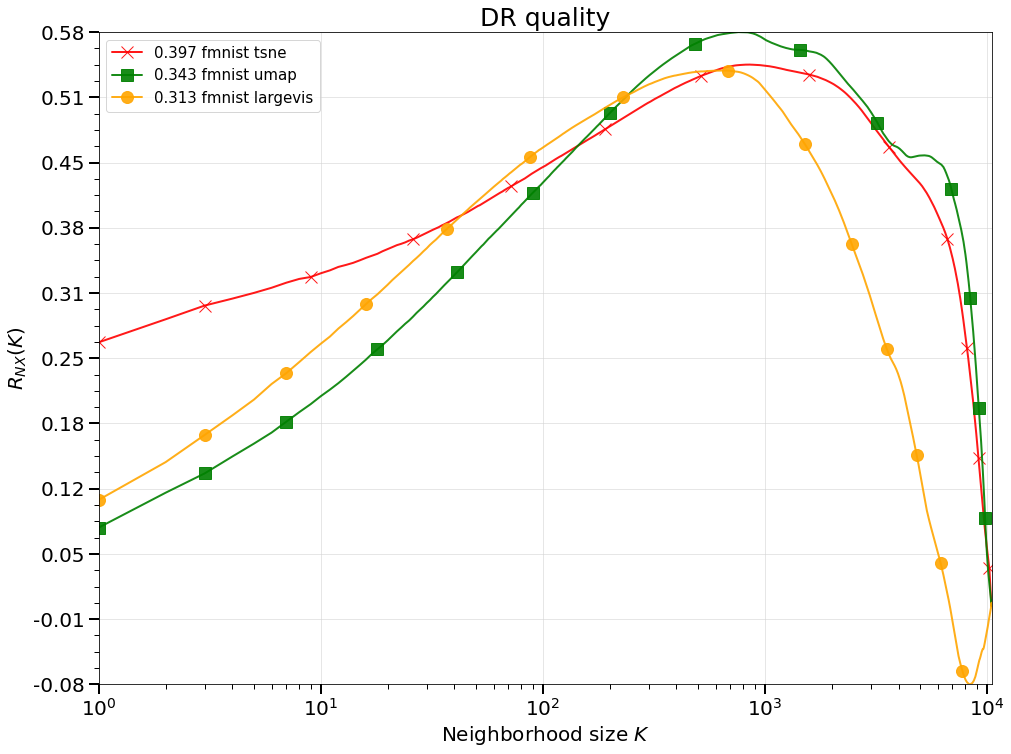

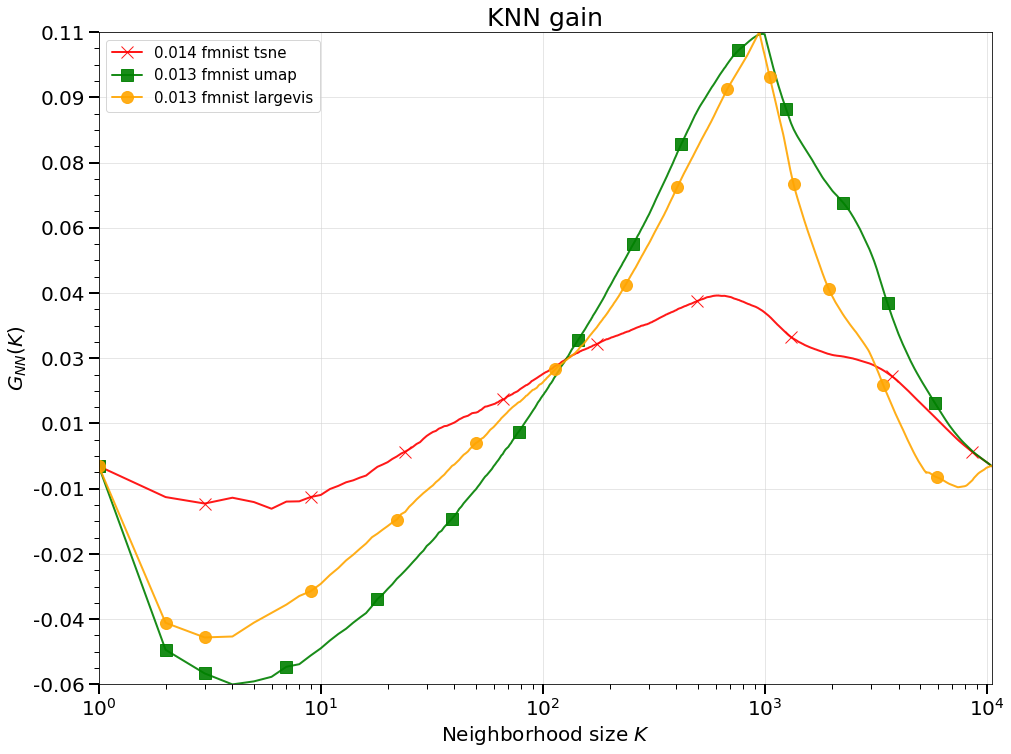

In [104]:
# largevis_mnist_data
fmnist_local_metrics.visualize()